<a href="https://colab.research.google.com/github/smitasasindran/era4/blob/session7/Session7/ERA4_Session7_Iteration1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Testing out a small model to get an idea about performance on CIFAR-10 with some random batch size, epochs, LR .. Ran on GPU, so could use higher batch size.   

Architecture: C1C2C3C40 (No MaxPooling, has 1x1, GAP, no FC)

## Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import numpy as np


In [ ]:
!pip install albumentations
import albumentations as A

## Data Transformations

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
    # A.HorizontalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),std=(0.2470, 0.2435, 0.2616))
])

# Test Phase transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),std=(0.2470, 0.2435, 0.2616))
])

## Dataset and Creating Train/Test Split


In [ ]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders

In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

batch_size = 512#256
cpu_batch_size = 128#64
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=cpu_batch_size)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Data Statistics

torch.Size([512, 3, 32, 32])
torch.Size([512])


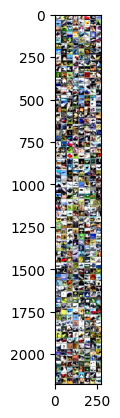

ship  bird  cat   dog   bird  truck truck plane plane ship  truck frog  bird  bird  dog   frog  ship  deer  horse truck horse horse dog   cat   cat   truck ship  plane car   truck frog  frog  bird  deer  frog  plane deer  truck car   car   horse cat   deer  ship  truck plane frog  ship  plane cat   bird  bird  frog  frog  plane truck cat   bird  ship  bird  bird  deer  bird  frog  ship  deer  deer  truck truck deer  horse cat   dog   truck truck dog   deer  car   dog   car   dog   dog   deer  truck bird  frog  ship  dog   ship  dog   frog  ship  car   dog   car   horse ship  frog  deer  deer  ship  cat   cat   frog  horse ship  horse car   car   truck bird  bird  dog   ship  truck cat   ship  deer  deer  dog   car   ship  dog   horse deer  cat   deer  car   dog   plane bird  truck cat   cat   cat   ship  horse frog  plane dog   bird  truck frog  dog   car   car   horse plane truck cat   bird  car   cat   car   deer  car   ship  horse plane frog  dog   truck deer  bird  car   deer  hors

In [ ]:
# Check some images

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

# img = np.moveaxis(images[0].numpy(), 0, -1)
# plt.imshow(img)

def imshow(img):
        img = img / 2 + 0.5  # Unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Show images
imshow(torchvision.utils.make_grid(images))

# Print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(len(labels))))



# figure = plt.figure()
# num_of_images = 60
# for index in range(1, num_of_images + 1):
#     plt.subplot(6, 10, index)
#     plt.axis('off')
#     plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Define the model

In [ ]:
dropout_value = 0.1

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        # Conv Block 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = b x 8 x 30 x 30

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 16 x 28 x 28

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # Conv Block 2 -------------------
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 24
        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 16 x 22 x 22

        self.conv7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 20

        self.conv8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 18


        # Conv Block 3 ---------------------
        self.conv9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 18
        self.conv10 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 16 x 16 x 16

        self.conv11 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 14

        self.conv12 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 12


        # Conv Block 4
        self.conv13 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 12
        self.conv14 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10

        self.conv15 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8

        self.conv16 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 6


        # Output
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.conv17 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.Dropout(dropout_value)
            # nn.ReLU()
        ) # output_size = 7



    def forward(self, x):
        # block1
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        # block2
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)

        # block3
        x = self.conv9(x)
        x = self.conv10(x)
        x = self.conv11(x)
        x = self.conv12(x)

        # block4
        x = self.conv13(x)
        x = self.conv14(x)
        x = self.conv15(x)
        x = self.conv16(x)

        # Output
        x = self.gap(x)
        x = self.conv17(x)
        x = x.view(-1, 10)

        return F.log_softmax(x, dim=-1)




## Model Summary

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 30, 30]             216
              ReLU-2            [-1, 8, 30, 30]               0
       BatchNorm2d-3            [-1, 8, 30, 30]              16
           Dropout-4            [-1, 8, 30, 30]               0
            Conv2d-5           [-1, 16, 28, 28]           1,152
              ReLU-6           [-1, 16, 28, 28]               0
       BatchNorm2d-7           [-1, 16, 28, 28]              32
           Dropout-8           [-1, 16, 28, 28]               0
            Conv2d-9           [-1, 16, 26, 26]           2,304
             ReLU-10           [-1, 16, 26, 26]               0
      BatchNorm2d-11           [-1, 16, 26, 26]              32
          Dropout-12           [-1, 16, 26, 26]               0
           Conv2d-13           [-1, 32, 24, 24]           4,608
             ReLU-14           [-1

## Train and Test loops

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

## Training

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 70
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=1.8758436441421509 Batch_id=97 Accuracy=21.27: 100%|██████████| 98/98 [00:13<00:00,  7.16it/s]



Test set: Average loss: 1.9941, Accuracy: 2531/10000 (25.31%)

EPOCH: 1


Loss=1.6375877857208252 Batch_id=97 Accuracy=33.41: 100%|██████████| 98/98 [00:13<00:00,  7.15it/s]



Test set: Average loss: 1.7405, Accuracy: 3525/10000 (35.25%)

EPOCH: 2


Loss=1.5462747812271118 Batch_id=97 Accuracy=39.90: 100%|██████████| 98/98 [00:13<00:00,  7.22it/s]



Test set: Average loss: 1.6147, Accuracy: 4120/10000 (41.20%)

EPOCH: 3


Loss=1.4126611948013306 Batch_id=97 Accuracy=44.34: 100%|██████████| 98/98 [00:14<00:00,  6.97it/s]



Test set: Average loss: 1.4956, Accuracy: 4531/10000 (45.31%)

EPOCH: 4


Loss=1.3574963808059692 Batch_id=97 Accuracy=47.63: 100%|██████████| 98/98 [00:13<00:00,  7.07it/s]



Test set: Average loss: 1.4579, Accuracy: 4744/10000 (47.44%)

EPOCH: 5


Loss=1.3225957155227661 Batch_id=97 Accuracy=49.49: 100%|██████████| 98/98 [00:14<00:00,  6.99it/s]



Test set: Average loss: 1.3980, Accuracy: 4982/10000 (49.82%)

EPOCH: 6


Loss=1.3728601932525635 Batch_id=97 Accuracy=51.24: 100%|██████████| 98/98 [00:14<00:00,  6.81it/s]



Test set: Average loss: 1.3434, Accuracy: 5148/10000 (51.48%)

EPOCH: 7


Loss=1.2479444742202759 Batch_id=97 Accuracy=52.80: 100%|██████████| 98/98 [00:14<00:00,  6.98it/s]



Test set: Average loss: 1.3038, Accuracy: 5273/10000 (52.73%)

EPOCH: 8


Loss=1.3133281469345093 Batch_id=97 Accuracy=53.75: 100%|██████████| 98/98 [00:14<00:00,  7.00it/s]



Test set: Average loss: 1.2687, Accuracy: 5396/10000 (53.96%)

EPOCH: 9


Loss=1.2356112003326416 Batch_id=97 Accuracy=54.78: 100%|██████████| 98/98 [00:14<00:00,  6.83it/s]



Test set: Average loss: 1.2449, Accuracy: 5508/10000 (55.08%)

EPOCH: 10


Loss=1.2753825187683105 Batch_id=97 Accuracy=55.58: 100%|██████████| 98/98 [00:14<00:00,  6.95it/s]



Test set: Average loss: 1.2512, Accuracy: 5458/10000 (54.58%)

EPOCH: 11


Loss=1.16744065284729 Batch_id=97 Accuracy=56.41: 100%|██████████| 98/98 [00:16<00:00,  6.12it/s]



Test set: Average loss: 1.2108, Accuracy: 5658/10000 (56.58%)

EPOCH: 12


Loss=1.139020323753357 Batch_id=97 Accuracy=57.32: 100%|██████████| 98/98 [00:14<00:00,  6.68it/s]



Test set: Average loss: 1.2210, Accuracy: 5621/10000 (56.21%)

EPOCH: 13


Loss=1.144014596939087 Batch_id=97 Accuracy=57.95: 100%|██████████| 98/98 [00:14<00:00,  6.93it/s]



Test set: Average loss: 1.2087, Accuracy: 5690/10000 (56.90%)

EPOCH: 14


Loss=1.1516331434249878 Batch_id=97 Accuracy=58.34: 100%|██████████| 98/98 [00:14<00:00,  6.80it/s]



Test set: Average loss: 1.2062, Accuracy: 5712/10000 (57.12%)

EPOCH: 15


Loss=1.121218204498291 Batch_id=97 Accuracy=59.09: 100%|██████████| 98/98 [00:14<00:00,  6.84it/s]



Test set: Average loss: 1.1700, Accuracy: 5819/10000 (58.19%)

EPOCH: 16


Loss=1.1232247352600098 Batch_id=97 Accuracy=59.82: 100%|██████████| 98/98 [00:14<00:00,  6.83it/s]



Test set: Average loss: 1.1667, Accuracy: 5819/10000 (58.19%)

EPOCH: 17


Loss=1.0746688842773438 Batch_id=97 Accuracy=60.14: 100%|██████████| 98/98 [00:14<00:00,  6.97it/s]



Test set: Average loss: 1.1334, Accuracy: 5924/10000 (59.24%)

EPOCH: 18


Loss=1.18605375289917 Batch_id=97 Accuracy=60.80: 100%|██████████| 98/98 [00:14<00:00,  6.90it/s]



Test set: Average loss: 1.1176, Accuracy: 6017/10000 (60.17%)

EPOCH: 19


Loss=1.049068808555603 Batch_id=97 Accuracy=60.67: 100%|██████████| 98/98 [00:14<00:00,  6.62it/s]



Test set: Average loss: 1.0937, Accuracy: 6084/10000 (60.84%)

EPOCH: 20


Loss=1.0664182901382446 Batch_id=97 Accuracy=60.97: 100%|██████████| 98/98 [00:14<00:00,  6.97it/s]



Test set: Average loss: 1.1117, Accuracy: 6060/10000 (60.60%)

EPOCH: 21


Loss=1.0089483261108398 Batch_id=97 Accuracy=61.17: 100%|██████████| 98/98 [00:14<00:00,  6.88it/s]



Test set: Average loss: 1.1246, Accuracy: 6062/10000 (60.62%)

EPOCH: 22


Loss=1.0660183429718018 Batch_id=97 Accuracy=61.68: 100%|██████████| 98/98 [00:14<00:00,  6.91it/s]



Test set: Average loss: 1.0961, Accuracy: 6101/10000 (61.01%)

EPOCH: 23


Loss=1.0790034532546997 Batch_id=97 Accuracy=62.09: 100%|██████████| 98/98 [00:15<00:00,  6.44it/s]



Test set: Average loss: 1.0926, Accuracy: 6152/10000 (61.52%)

EPOCH: 24


Loss=1.0234687328338623 Batch_id=97 Accuracy=62.38: 100%|██████████| 98/98 [00:14<00:00,  6.85it/s]



Test set: Average loss: 1.0908, Accuracy: 6120/10000 (61.20%)

EPOCH: 25


Loss=1.0497701168060303 Batch_id=97 Accuracy=62.37: 100%|██████████| 98/98 [00:14<00:00,  6.88it/s]



Test set: Average loss: 1.0741, Accuracy: 6214/10000 (62.14%)

EPOCH: 26


Loss=1.0992553234100342 Batch_id=97 Accuracy=63.17: 100%|██████████| 98/98 [00:14<00:00,  6.90it/s]



Test set: Average loss: 1.0487, Accuracy: 6211/10000 (62.11%)

EPOCH: 27


Loss=1.053420066833496 Batch_id=97 Accuracy=63.06: 100%|██████████| 98/98 [00:14<00:00,  7.00it/s]



Test set: Average loss: 1.1306, Accuracy: 6021/10000 (60.21%)

EPOCH: 28


Loss=0.8694618940353394 Batch_id=97 Accuracy=63.35: 100%|██████████| 98/98 [00:14<00:00,  6.98it/s]



Test set: Average loss: 1.0678, Accuracy: 6230/10000 (62.30%)

EPOCH: 29


Loss=0.9503253698348999 Batch_id=97 Accuracy=63.79: 100%|██████████| 98/98 [00:14<00:00,  6.59it/s]



Test set: Average loss: 1.0739, Accuracy: 6205/10000 (62.05%)

EPOCH: 30


Loss=0.9866521954536438 Batch_id=97 Accuracy=63.67: 100%|██████████| 98/98 [00:14<00:00,  6.70it/s]



Test set: Average loss: 1.0395, Accuracy: 6248/10000 (62.48%)

EPOCH: 31


Loss=1.0254261493682861 Batch_id=97 Accuracy=63.94: 100%|██████████| 98/98 [00:14<00:00,  6.87it/s]



Test set: Average loss: 1.0484, Accuracy: 6224/10000 (62.24%)

EPOCH: 32


Loss=1.000677227973938 Batch_id=97 Accuracy=64.00: 100%|██████████| 98/98 [00:14<00:00,  6.74it/s]



Test set: Average loss: 1.0933, Accuracy: 6127/10000 (61.27%)

EPOCH: 33


Loss=1.0974096059799194 Batch_id=97 Accuracy=64.34: 100%|██████████| 98/98 [00:14<00:00,  6.94it/s]



Test set: Average loss: 1.0660, Accuracy: 6202/10000 (62.02%)

EPOCH: 34


Loss=0.9938486814498901 Batch_id=97 Accuracy=64.50: 100%|██████████| 98/98 [00:14<00:00,  6.93it/s]



Test set: Average loss: 1.0707, Accuracy: 6252/10000 (62.52%)

EPOCH: 35


Loss=0.9703316688537598 Batch_id=97 Accuracy=64.95: 100%|██████████| 98/98 [00:14<00:00,  6.99it/s]



Test set: Average loss: 1.0776, Accuracy: 6245/10000 (62.45%)

EPOCH: 36


Loss=1.0202821493148804 Batch_id=97 Accuracy=64.76: 100%|██████████| 98/98 [00:14<00:00,  6.72it/s]



Test set: Average loss: 1.0464, Accuracy: 6311/10000 (63.11%)

EPOCH: 37


Loss=0.886685848236084 Batch_id=97 Accuracy=65.04: 100%|██████████| 98/98 [00:13<00:00,  7.11it/s]



Test set: Average loss: 0.9812, Accuracy: 6504/10000 (65.04%)

EPOCH: 38


Loss=0.8703739643096924 Batch_id=97 Accuracy=65.27: 100%|██████████| 98/98 [00:13<00:00,  7.12it/s]



Test set: Average loss: 1.0050, Accuracy: 6490/10000 (64.90%)

EPOCH: 39


Loss=0.9370794892311096 Batch_id=97 Accuracy=65.49: 100%|██████████| 98/98 [00:14<00:00,  6.86it/s]



Test set: Average loss: 1.0099, Accuracy: 6409/10000 (64.09%)

EPOCH: 40


Loss=0.9831475615501404 Batch_id=97 Accuracy=65.45: 100%|██████████| 98/98 [00:15<00:00,  6.51it/s]



Test set: Average loss: 1.0265, Accuracy: 6392/10000 (63.92%)

EPOCH: 41


Loss=0.9413050413131714 Batch_id=97 Accuracy=65.77: 100%|██████████| 98/98 [00:13<00:00,  7.02it/s]



Test set: Average loss: 1.0297, Accuracy: 6365/10000 (63.65%)

EPOCH: 42


Loss=0.9742280840873718 Batch_id=97 Accuracy=65.64: 100%|██████████| 98/98 [00:13<00:00,  7.09it/s]



Test set: Average loss: 0.9835, Accuracy: 6500/10000 (65.00%)

EPOCH: 43


Loss=0.971746563911438 Batch_id=97 Accuracy=65.86: 100%|██████████| 98/98 [00:13<00:00,  7.02it/s]



Test set: Average loss: 1.0157, Accuracy: 6411/10000 (64.11%)

EPOCH: 44


Loss=0.9429314136505127 Batch_id=97 Accuracy=66.26: 100%|██████████| 98/98 [00:13<00:00,  7.06it/s]



Test set: Average loss: 0.9963, Accuracy: 6558/10000 (65.58%)

EPOCH: 45


Loss=0.872020423412323 Batch_id=97 Accuracy=66.31: 100%|██████████| 98/98 [00:13<00:00,  7.00it/s]



Test set: Average loss: 1.0245, Accuracy: 6420/10000 (64.20%)

EPOCH: 46


Loss=0.9257968664169312 Batch_id=97 Accuracy=66.28: 100%|██████████| 98/98 [00:14<00:00,  6.97it/s]



Test set: Average loss: 0.9695, Accuracy: 6626/10000 (66.26%)

EPOCH: 47


Loss=0.9112929105758667 Batch_id=97 Accuracy=66.48: 100%|██████████| 98/98 [00:14<00:00,  6.99it/s]



Test set: Average loss: 0.9792, Accuracy: 6527/10000 (65.27%)

EPOCH: 48


Loss=0.9688542485237122 Batch_id=97 Accuracy=66.65: 100%|██████████| 98/98 [00:13<00:00,  7.01it/s]



Test set: Average loss: 0.9971, Accuracy: 6541/10000 (65.41%)

EPOCH: 49


Loss=0.9623993635177612 Batch_id=97 Accuracy=66.55: 100%|██████████| 98/98 [00:13<00:00,  7.06it/s]



Test set: Average loss: 1.0100, Accuracy: 6477/10000 (64.77%)

EPOCH: 50


Loss=0.9277728199958801 Batch_id=97 Accuracy=66.93: 100%|██████████| 98/98 [00:14<00:00,  6.93it/s]



Test set: Average loss: 0.9852, Accuracy: 6524/10000 (65.24%)

EPOCH: 51


Loss=0.938287079334259 Batch_id=97 Accuracy=66.75: 100%|██████████| 98/98 [00:13<00:00,  7.07it/s]



Test set: Average loss: 0.9647, Accuracy: 6627/10000 (66.27%)

EPOCH: 52


Loss=0.9736400842666626 Batch_id=97 Accuracy=67.07: 100%|██████████| 98/98 [00:13<00:00,  7.09it/s]



Test set: Average loss: 0.9808, Accuracy: 6593/10000 (65.93%)

EPOCH: 53


Loss=0.934004545211792 Batch_id=97 Accuracy=67.28: 100%|██████████| 98/98 [00:13<00:00,  7.25it/s]



Test set: Average loss: 1.0007, Accuracy: 6566/10000 (65.66%)

EPOCH: 54


Loss=0.9290459156036377 Batch_id=97 Accuracy=67.16: 100%|██████████| 98/98 [00:13<00:00,  7.00it/s]



Test set: Average loss: 0.9780, Accuracy: 6604/10000 (66.04%)

EPOCH: 55


Loss=0.9986792206764221 Batch_id=97 Accuracy=67.23: 100%|██████████| 98/98 [00:14<00:00,  6.95it/s]



Test set: Average loss: 0.9941, Accuracy: 6562/10000 (65.62%)

EPOCH: 56


Loss=0.911662757396698 Batch_id=97 Accuracy=67.42: 100%|██████████| 98/98 [00:14<00:00,  6.82it/s]



Test set: Average loss: 0.9717, Accuracy: 6617/10000 (66.17%)

EPOCH: 57


Loss=0.9115269780158997 Batch_id=97 Accuracy=67.90: 100%|██████████| 98/98 [00:14<00:00,  6.76it/s]



Test set: Average loss: 0.9427, Accuracy: 6729/10000 (67.29%)

EPOCH: 58


Loss=0.9300849437713623 Batch_id=97 Accuracy=67.70: 100%|██████████| 98/98 [00:14<00:00,  6.99it/s]



Test set: Average loss: 0.9599, Accuracy: 6640/10000 (66.40%)

EPOCH: 59


Loss=0.9149542450904846 Batch_id=97 Accuracy=67.87: 100%|██████████| 98/98 [00:13<00:00,  7.05it/s]



Test set: Average loss: 0.9290, Accuracy: 6750/10000 (67.50%)

EPOCH: 60


Loss=1.0075621604919434 Batch_id=97 Accuracy=67.91: 100%|██████████| 98/98 [00:14<00:00,  6.97it/s]



Test set: Average loss: 0.9453, Accuracy: 6722/10000 (67.22%)

EPOCH: 61


Loss=0.8535210490226746 Batch_id=97 Accuracy=68.04: 100%|██████████| 98/98 [00:13<00:00,  7.00it/s]



Test set: Average loss: 0.9725, Accuracy: 6689/10000 (66.89%)

EPOCH: 62


Loss=0.9922119379043579 Batch_id=97 Accuracy=67.79: 100%|██████████| 98/98 [00:13<00:00,  7.10it/s]



Test set: Average loss: 0.9637, Accuracy: 6662/10000 (66.62%)

EPOCH: 63


Loss=0.9394276738166809 Batch_id=97 Accuracy=68.41: 100%|██████████| 98/98 [00:13<00:00,  7.26it/s]



Test set: Average loss: 0.9741, Accuracy: 6630/10000 (66.30%)

EPOCH: 64


Loss=0.8215306401252747 Batch_id=97 Accuracy=68.54: 100%|██████████| 98/98 [00:13<00:00,  7.25it/s]



Test set: Average loss: 0.9727, Accuracy: 6624/10000 (66.24%)

EPOCH: 65


Loss=0.7907342314720154 Batch_id=97 Accuracy=68.08: 100%|██████████| 98/98 [00:14<00:00,  6.97it/s]



Test set: Average loss: 0.9397, Accuracy: 6745/10000 (67.45%)

EPOCH: 66


Loss=0.7304823994636536 Batch_id=97 Accuracy=68.46: 100%|██████████| 98/98 [00:13<00:00,  7.12it/s]



Test set: Average loss: 0.9838, Accuracy: 6598/10000 (65.98%)

EPOCH: 67


Loss=0.8174033164978027 Batch_id=97 Accuracy=68.56: 100%|██████████| 98/98 [00:13<00:00,  7.17it/s]



Test set: Average loss: 0.9272, Accuracy: 6767/10000 (67.67%)

EPOCH: 68


Loss=0.8627771735191345 Batch_id=97 Accuracy=68.53: 100%|██████████| 98/98 [00:13<00:00,  7.26it/s]



Test set: Average loss: 0.9448, Accuracy: 6737/10000 (67.37%)

EPOCH: 69


Loss=0.9486004710197449 Batch_id=97 Accuracy=68.64: 100%|██████████| 98/98 [00:13<00:00,  7.24it/s]



Test set: Average loss: 0.9280, Accuracy: 6775/10000 (67.75%)



## Accuracy and Loss curves

Text(0.5, 1.0, 'Test Accuracy')

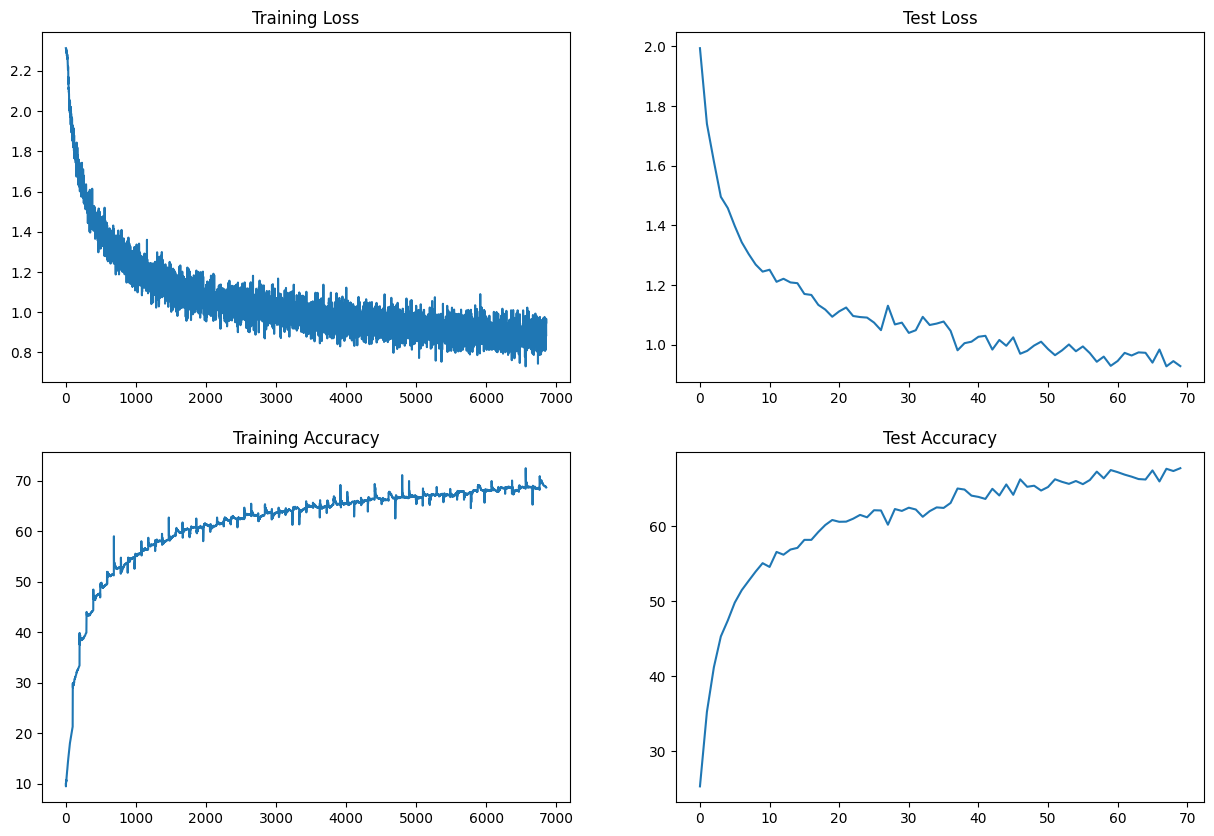

In [ ]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")